In [1]:
# Testing out strain rate error calculation
import sys
import pandas as pd
sys.path.append("../../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math
from datetime import datetime

# To run
def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

def convert_to_seconds(s):
    seconds_per_unit = {"S": 1, "T": 60, "H": 3600, "D": 86400, "W": 604800}
    return int(s[:-1]) * seconds_per_unit[s[-1]]


In [97]:
# To alter

# Station
station = 'A101'

# Stacking of profiles
stacking = '1H'

# Window for vertical displacement
vd_window = 19

# Resolution of displacement resample
vd_sum = '1D'

# Factor for vertical coarsening of displacements
vd_coarse = 1

In [98]:
xa = ApRESDefs.xapres(loglevel='debug')
ds_winter = reload_winter(station)
current_time = datetime.now().strftime("%H:%M:%S")
print(f'{current_time}: Data loaded')

# Determine profiles
profiles = ds_winter.isel(attenuator_setting_pair=0,time=range(1,len(ds_winter.time))).profile_stacked.resample(time=stacking).mean(dim='time').compute()

current_time = datetime.now().strftime("%H:%M:%S")
print(f'{current_time}: Profiles calculated')

# Calculate displacements
b1 = profiles.isel(time=range(0,len(profiles.time)-1)).where(profiles.profile_range >= 10,drop=True).compute()
b2 = profiles.isel(time=range(1,len(profiles.time))).where(profiles.profile_range >= 10,drop=True).compute()
ds, co, phi = xa.generate_range_diff(b1,b2,vd_window,vd_window,None,0,0.9)
ds

DEBUG    18:56:41 	 ApRESDefs.py @function _setup_logging line 539 - Stream logging level set to DEBUG
DEBUG    18:56:41 	 ApRESDefs.py @function _setup_logging line 540 - Add console handler to logger
DEBUG    18:56:41 	 ApRESDefs.py @function _setup_logging line 553 - File logging level set to DEBUG
18:56:41: Data loaded
18:57:10: Profiles calculated
INFO     18:57:12 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [3600. 3600. 3600. ... 3600. 3600. 3600.]s


<xarray.Dataset>
Dimensions:        (time: 5738, profile_range: 347)
Coordinates:
  * time           (time) datetime64[ns] 2022-09-25T16:00:00 ... 2023-05-22T1...
  * profile_range  (profile_range) float64 11.99 15.98 ... 1.39e+03 1.394e+03
Data variables:
    time_diff      (time) float64 3.6e+03 7.2e+03 ... 2.065e+07 2.066e+07
    range_diff     (time, profile_range) float64 0.003157 0.002112 ... 0.003314
    err            (time, profile_range) float64 0.0008137 0.005143 ... 0.02154

In [99]:
# now do the cumsum for the displacements
disp_stack = ds.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
strain_polyfit = disp_stack.range_diff.where(disp_stack.profile_range <= 500,drop=True).polyfit('profile_range',1)

In [100]:
test = disp_stack.isel(time=10)
test

<xarray.Dataset>
Dimensions:        (profile_range: 347)
Coordinates:
  * profile_range  (profile_range) float64 11.99 15.98 ... 1.39e+03 1.394e+03
    time           datetime64[ns] 2022-10-05
Data variables:
    time_diff      float64 7.458e+09
    range_diff     (profile_range) float64 -0.781 -12.25 -10.75 ... -8.308 8.319
    err            (profile_range) float64 2.619 14.65 11.31 ... 34.65 60.79

<ErrorbarContainer object of 3 artists>

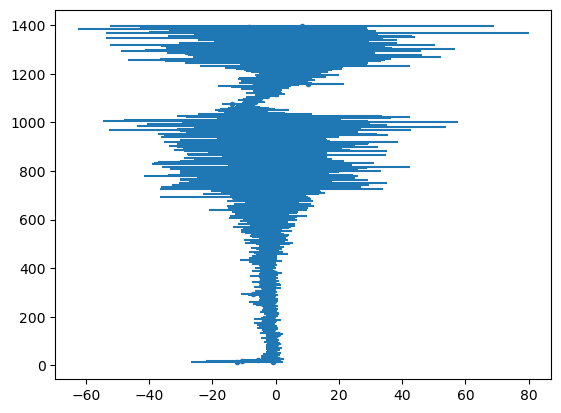

In [101]:
plt.errorbar(test.range_diff,test.profile_range,yerr=None,xerr=test.err,linestyle='',marker='.')

In [102]:
# now we try error propogation with proper equation
def sum_error(errs):
    return np.sqrt(np.sum(errs**2))
def special_func(data):
    return xr.apply_ufunc(sum_error, data, input_core_dims=[["time"]], vectorize = True)

In [103]:
# now do the cumsum for the displacements
disp_stack = ds.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
strain_polyfit = disp_stack.where(disp_stack.profile_range <= 500,drop=True).polyfit('profile_range',1)
err_stack = ds.err.resample(time=vd_sum).apply(special_func)/convert_to_seconds(vd_sum)*31536000

<ErrorbarContainer object of 3 artists>

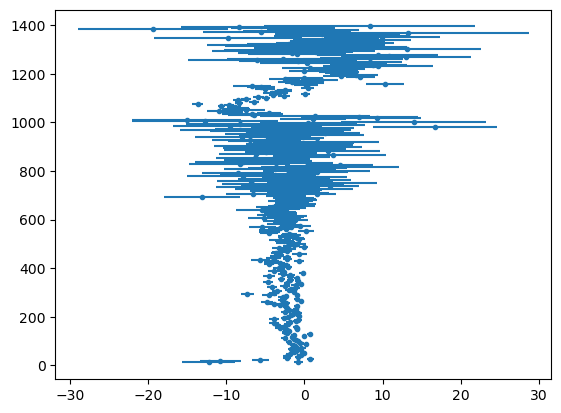

In [104]:
test = disp_stack.isel(time=10)
err = err_stack.isel(time=10)
plt.errorbar(test,test.profile_range,yerr=None,xerr=err,linestyle='',marker='.')